In machine learning, the train-dev-test split is a common technique used to evaluate the performance of a model and prevent overfitting. The dataset is divided into three subsets: the training set, the development (or validation) set, and the test set.

The benchmark comprises 8628 sentence pairs. This is the breakdown according to genres and train-dev-test splits:

                train  dev test total 
        -----------------------------
        news     3299  500  500  4299
        caption  2000  625  525  3250
        forum     450  375  254  1079
        -----------------------------
        total    5749 1500 1379  8628

## Preliminary analysis
- [x] Calculate average document length
- [x] Calculate average vocabulary size
- [x] Calculate average sentence length
- [ ] Check if scores are balanced
- [ ] Topic clustering
- [ ] Keyword search
- [ ] Word2Vec embedding

<input type="checkbox"> Checkbox item 1<br>
<input type="checkbox" disabled> Checkbox item 2<br>
<input type="checkbox" disabled> Checkbox item 3<br>

In [5]:
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from unidecode import unidecode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {df.shape}')
df.head(10)

shape of the Dataframe (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [7]:
sentences1 = df["sentence1"]
sentences2 = df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


In [8]:
regex = '[' + punctuation + ']'
clean_sentences_list = np.array([re.sub(regex,'',unidecode(string)).lower() for string in sentences_list])
print(sentences_list)
print(clean_sentences_list)

[' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ...
 'zhang yan stated that all countries should abide by non-proliferation obligations in order to enhance mutual trust and create a sound environment for international cooperation in nuclear energy.'
 'zhang yan stated that china opposes using non-proliferation as a pretext for restricting and depriving non-nuclear-weapon states of the right to peaceful use of nuclear energy.'
 '‚ÄėGlee‚Äô star Cory Monteith found dead in hotel room']
['  income top rate  percent' ' foxe was mostly frozen'
 ' billion  everyone in the world at mexicos current prosperity level' ...
 'zhang yan stated that all countries should abide by nonproliferation obligations in order to enhance mutual trust and create a sound environment for international cooperation in nuclear energy'
 'zhang yan stated that china opposes using nonproliferation as a pretext for restricting and de

We perform also lemmatization to group word with the same base form as lemma and improve models trained on our dataset

In [9]:
!pip install -U spacy

In [10]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
     ----                                     1.4/12.8 MB 30.1 MB/s eta 0:00:01
     ---------                                3.1/12.8 MB 33.3 MB/s eta 0:00:01
     ---------------                          4.8/12.8 MB 34.5 MB/s eta 0:00:01
     ----------------------                   7.2/12.8 MB 38.3 MB/s eta 0:00:01
     --------------------------               8.5/12.8 MB 38.7 MB/s eta 0:00:01
     ------------------------------          10.1/12.8 MB 35.9 MB/s eta 0:00:01
     ------------------------------------    11.9/12.8 MB 38.5 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 38.5 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 38.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 27.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
import spacy
import en_core_web_sm
spacy_model = en_core_web_sm.load()

In [68]:
@np.vectorize
def parse_single_sentence(sentence):
    parsed_sentence = spacy_model(str(sentence))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence

parsed_sentences = parse_single_sentence(clean_sentences_list)

In [41]:
print(parsed_sentences[:100])

['   income top rate   percent' '  foxe be mostly freeze'
 '  billion   everyone in the world at mexicos current prosperity level'
 '  warmedc from the year prior'
 'americans do not cut and run we have to see this misadventure through she say'
 'and about eight to 10 second down I hit'
 'at first blush it do not look like any rule be break say gen richard myers chairman of the joint chief of staff'
 'be against nuke do not mean not want to use nuke'
 'be against use nuke mean not want to use nuke'
 'biotech product if anything may be safe than conventional product because of all the testing fraley say add that 18 country have adopt biotechnology'
 'biotech product if anything may be safe than conventional product because of all the testing say robert fraley monsantos executive vice president'
 'bright but scatterbraine become treat with drug'
 'but I do question the motive of a deskbound president who assume the garb of a warrior for the purpose of a speech'
 'but I do question the mo

In [32]:
# Transform th parsed sentences to an array of strings
parsed_sentences = np.array([str(sentence) for sentence in parsed_sentences])

In [33]:
# Saving the file to a txt
with open('Dataset/parsed_sentences.txt', 'w') as f:
    for item in parsed_sentences:
        f.write("%s\n" % item)


In [6]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


Maximum sentence length: 56
Minimum sentence length: 2
Mean length of sentences in words: 10.17


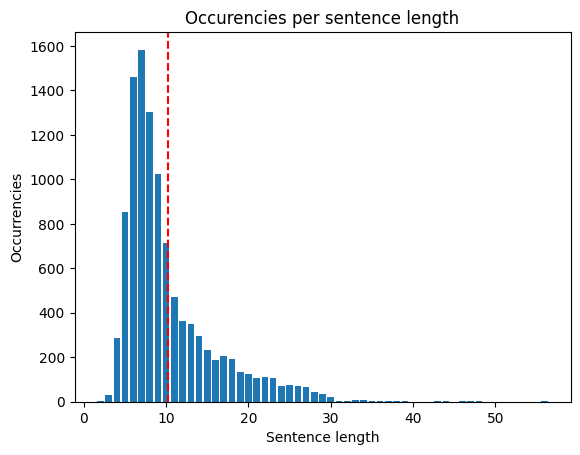

In [6]:
arr_words = np.array([len(s.split()) for s in sentences_list])

print(f"Maximum sentence length: {np.max(arr_words)}")
print(f"Minimum sentence length: {np.min(arr_words)}")

mean_sentences_length = np.mean(arr_words);
print(f"Mean length of sentences in words: {mean_sentences_length:.2f}")

unique, counts = np.unique(arr_words, return_counts=True)

plt.bar(unique, counts)

plt.axvline(x=mean_sentences_length, color='r', linestyle='--')

plt.xlabel("Sentence length")
plt.ylabel("Occurrencies")
plt.title("Occurencies per sentence length")


plt.show()

In [7]:
words_with_duplicates = [word for string in clean_sentences_list for word in word_tokenize(string)]
words_nostopwords = [w for w in words_with_duplicates if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(20)

[('man', 853),
 ('woman', 547),
 ('two', 458),
 ('said', 455),
 ('dog', 418),
 ('us', 402),
 ('white', 282),
 ('killed', 265),
 ('black', 258),
 ('playing', 254),
 ('percent', 253),
 ('new', 238),
 ('people', 217),
 ('syria', 211),
 ('china', 191),
 ('police', 173),
 ('running', 170),
 ('president', 168),
 ('person', 161),
 ('water', 156)]

In [8]:
vocabulary = np.unique(words_nostopwords)
print(len(vocabulary))
print(vocabulary)

12243
['0' '004' '005' ... 'zubaidi' 'zuccarini' 'zuma']


Mean scores of sentence similarity: 2.70


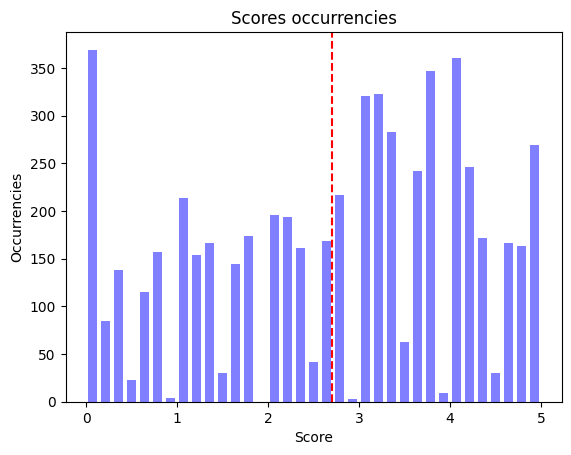

In [9]:
tot_scores = df["score"]
scores = np.ravel(tot_scores.values)

mean_scores = np.mean(scores);
print(f"Mean scores of sentence similarity: {mean_scores:.2f}")

plt.hist(scores, bins=35, alpha=0.5, color='blue', rwidth=0.7)

plt.axvline(x=mean_scores, color='r', linestyle='--')

plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.title("Scores occurrencies")

plt.show()

## Text Clustering

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.sparse as scs

In [38]:
# creazione della matrice di similarità
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english', strip_accents='ascii')
tfidf_matrix = tfidf.fit_transform(clean_sentences_list)
vocab = tfidf.get_feature_names_out()

print(tfidf_matrix.shape)
print(vocab)

(10566, 2782)
['04' '07' '10' ... 'zimbabwe' 'zimmerman' 'zone']


In [36]:
word = 'dog'
word_id = tfidf.transform([word]).nonzero()[1]
filter = tfidf_matrix.getcol(word_id).nonzero()[0]
print(f'The word {word} is present in {len(filter)} documents. Here\'s the first 5:')
for idx, sentence in enumerate(clean_sentences_list[filter][:5]):
    print(str(idx + 1) + '.' , sentence)

The word dog is present in 406 documents. Here's the first 5:
1. a baby is playing with a dog
2. a baby plays with a dog and ball
3. a black and a brown dog running in the grass
4. a black and a yellow dog
5. a black and brown dog runs through the woods


[[1.16756416 1.08627726 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 [1.16756416 1.08145617 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 [1.16756416 1.08471442 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 ...
 [1.16756416 1.08535077 1.10761214 ... 1.09864128 1.07127939 1.09486491]
 [1.16756416 1.08250989 1.10628172 ... 1.09579484 1.06382312 1.09289389]
 [1.16756416 1.08599723 1.10048874 ... 1.09864128 1.07390301 1.09546637]]
[26 18 18 ...  6  6  9]


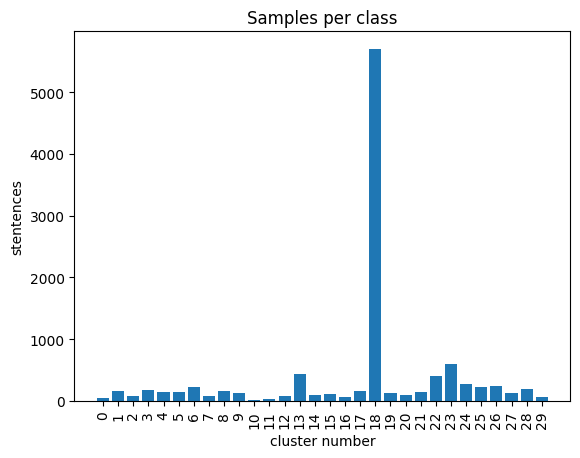

In [19]:
#TODO remove
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(tfidf_matrix)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('cluster number')
plt.ylabel('stentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

In [21]:
print(clean_sentences_list[clusters==2]) #TODO remove

[' foxe was mostly frozen'
 ' billion  everyone in the world at mexicos current prosperity level'
 ' warmedc from the year prior' ...
 'you have no witnesses for a missile at the pentagon'
 'zahedan is a city in southeastern '
 'zahedan is the capital of sistanbaluchestan province']


In [33]:
#TODO remove
for i in range(1):
    for s in tfidf_matrix[clusters==i]:
        print(np.max(s.todense())) 

0.5870727403663625
0.7353936155065361
0.7103763479164953
0.5402747929881593
0.7223409304405293
0.6063079616711494
0.5860390309734199
0.6463372632261329
0.5737025897764455
0.634673043023743
0.6466613598720016
0.6033627013988818
0.6396176738107257
0.5517754962619135
0.6222596102742358
0.4964846827381316
0.5697736352116076
0.6508202625781111
0.6983895817696577
0.611374806942692
0.5323453011908882
0.6338239438104344
0.709491129627362
0.5436806442721329
0.6922453490958373
0.5685635796735165
0.5201631985680353
0.5652781721313052
0.5639638933350086
0.6508202625781111
0.5911826741882329
0.6476068371176784
0.5305980973476908
0.7750077398638888
0.5251448512981151
0.6116367179805876
0.5200165719238552
0.8106207064495318
0.46805143362563406
0.5650682536664466
0.7339910677157546
0.7437625035734563
0.6270110095405649
0.6825726438328226
0.7647182789673328


In [20]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['sheep', 'standing', 'black', 'field', 'hill']
Cluster 1:	['people', 'group', 'table', 'walking', 'dancing']
Cluster 2:	['sitting', 'table', 'people', 'women', 'man']
Cluster 3:	['playing', 'guitar', 'man', 'dogs', 'flute']
Cluster 4:	['girl', 'little', 'young', 'riding', 'horse']
Cluster 5:	['running', 'dog', 'grass', 'dogs', 'brown']
Cluster 6:	['nuclear', 'iran', 'korea', 'north', 'talks']
Cluster 7:	['train', 'tracks', 'station', 'track', 'passenger']
Cluster 8:	['president', 'visit', 'vice', 'sworn', 'state']
Cluster 9:	['dead', 'shooting', 'crash', 'injured', 'train']
Cluster 10:	['shrimp', 'woman', 'peels', 'peeling', 'cleaning']
Cluster 11:	['cross', 'lebanon', 'russians', 'red', 'syria']
Cluster 12:	['red', 'bus', 'decker', 'double', 'street']
Cluster 13:	['woman', 'slicing', 'man', 'riding', 'meat']
Cluster 14:	['standing', 'field', 'man', 'black', 'cow']
Cluster 15:	['death', 'toll', 'rises', 'penalty', 'bangladesh']
Cluster 16:	['cutting',

# Training models

## Bag of Words

We just trained a tf-idf model to compute clusters. We can also use this model to compute similarity between sentences using a bag of words approach.

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english', strip_accents='ascii')
#tfidf_matrix = tfidf_vectorizer.fit_transform(clean_sentences_list)
tfidf_matrix = tfidf_vectorizer.fit_transform(parsed_sentences)
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

print(f"The dataset contains {len(tfidf_vocab)} terms")
np.random.seed(41)
random_sentence = np.random.choice(parsed_sentences)
print("Random sentence:", random_sentence)
print()
random_sentence_tfidf_scores = tfidf_vectorizer.transform([random_sentence])
pd.DataFrame({
    "id": random_sentence_tfidf_scores.nonzero()[1],
    "word": tfidf_vocab[random_sentence_tfidf_scores.nonzero()[1]],
    "scores": random_sentence_tfidf_scores.data
})

The dataset contains 2433 terms
Random sentence: a person be hitchhike on a road



,id,word,scores
0,1855,road,0.772315
1,1599,person,0.635240


Now we print the most similar sentences of a selected one using cosine similarity

In [53]:
tfidf_similarity = cosine_similarity(tfidf_matrix)
tfidf_sentence_idx = 10
print(clean_sentences_list[tfidf_sentence_idx])
for i, col_idx in enumerate(tfidf_similarity[tfidf_sentence_idx].argsort()[::-1][1:6]):
    print(str(i+1) + ")",f"{tfidf_similarity[tfidf_sentence_idx][col_idx]:.2f}", clean_sentences_list[col_idx])

biotech products if anything may be safer than conventional products because of all the testing said robert fraley monsantos executive vice president
1) 0.69 biotech products if anything may be safer than conventional products because of all the testing fraley said adding that 18 countries have adopted biotechnology
2) 0.54 the onus is on the manufacturer of a product to convince consumers it is safe
3) 0.38 products featuring vanderpool will be released within five years he said
4) 0.36 as executive vice president of new ventures elias will report to joe tucci emcs president and chief executive
5) 0.33 the product can be instructed to permit businessonly use according to sendmail


In [64]:
idx, row = next(df.iterrows())
str(parse_single_sentence(row["sentence1"]))
str(parse_single_sentence(row["sentence2"]))


'an air plane be take off .'

In [71]:
from sklearn.metrics import mean_squared_error

def evaluate_mse(model):
    predicted_scores = []
    for idx, row in df.iterrows():
        vectorized_sentences = model.transform([str(parse_single_sentence(row["sentence1"])), str(parse_single_sentence(row["sentence2"]))])
        similarity = cosine_similarity(vectorized_sentences)
        predicted_scores.append(similarity[0][1])
    return mean_squared_error(df["score"].values / 5, predicted_scores)


In [72]:
print("MSE:", evaluate_mse(tfidf_vectorizer))

MSE: 0.056237662780198636


We try to improve it using trigrams

In [76]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, strip_accents='ascii', ngram_range=(2,2))
#tfidf_matrix = tfidf_vectorizer.fit_transform(clean_sentences_list)
tfidf_matrix = tfidf_vectorizer.fit_transform(parsed_sentences)
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

print(f"The dataset contains {len(tfidf_vocab)} terms")
np.random.seed(41)
random_sentence = np.random.choice(clean_sentences_list)
print("Random sentence:", random_sentence)
print()
random_sentence_tfidf_scores = tfidf_vectorizer.transform([random_sentence])
pd.DataFrame({
    "id": random_sentence_tfidf_scores.nonzero()[1],
    "word": tfidf_vocab[random_sentence_tfidf_scores.nonzero()[1]],
    "scores": random_sentence_tfidf_scores.data
})

The dataset contains 15421 terms
Random sentence: a person is hitchhiking on a road



,id,word,scores
0,9362,on road,1.0


In [77]:
print("MSE:", evaluate_mse(tfidf_vectorizer))
#TODO cercare su internet comparazione performance bigrammi monogrammi

MSE: 0.1027378187370247


In [33]:
def substitute_number(text):
    pattern = r'\d+'
    replacement = ' [number] '
    substituted_text = re.sub(pattern, replacement, text)
    return substituted_text

temp = np.vectorize(substitute_number)(clean_sentences_list)

print(temp[:100])


['  income top rate  percent' ' foxe was mostly frozen'
 ' billion  everyone in the world at mexicos current prosperity level'
 ' warmedc from the year prior'
 'americans dont cut and run we have to see this misadventure through she said'
 'and about eight to  [number]  seconds down i hit'
 'at first blush it doesnt look like any rules were broken said gen richard myers chairman of the joint chiefs of staff'
 'being against nukes does not mean not wanting to use nukes'
 'being against using nukes means not wanting to use nukes'
 'biotech products if anything may be safer than conventional products because of all the testing fraley said adding that  [number]  countries have adopted biotechnology'
 'biotech products if anything may be safer than conventional products because of all the testing said robert fraley monsantos executive vice president'
 'bright but scatterbrained becomes treat with drugs'
 'but i do question the motives of a deskbound president who assumes the garb of a warri

## Word2Vec

In [ ]:
from gensim.models import Word2Vec

analyzer = tfidf.build_analyzer()
tokenized_corpus = [analyzer(w) for w in corpus]
model = Word2Vec(tokenized_corpus, vector_size=30, min_count=5, window=10)
print(len(model.wv))

2892


In [ ]:
# todo fare con operazioni vettoriali
def mix(vectorizer: TfidfVectorizer, embeddings: Word2Vec, document) -> np.array:
    vectorized = vectorizer.transform([document])
    cols = vectorized.nonzero()[1]
    result = np.zeros(30)
    weights = 0
    terms = tfidf.get_feature_names_out()

    for x in cols:
        word = terms[x]
        try:
            embed = embeddings.wv[word]
        except:
            continue
        weight = vectorized[0, x]
        result += weight * embed
        weights += weight
        
    result = result / weights
    if (np.isnan(result).any() or weights == 0):
        return np.zeros(30)
    return result

In [ ]:
mixed_corpus = np.array([mix(tfidf, model, w) for w in corpus])

/tmp/ipykernel_25521/2236178505.py:18: RuntimeWarning: invalid value encountered in divide
  result = result / weights


(11498, 30)
Initialization complete
Iteration 0, inertia 298.8018460750988.
Iteration 1, inertia 219.55690562598215.
Iteration 2, inertia 214.6848562331368.
Iteration 3, inertia 212.857355852252.
Iteration 4, inertia 212.23368635999134.
Iteration 5, inertia 211.92467648426236.
Iteration 6, inertia 211.6976908654495.
Iteration 7, inertia 211.47532825632214.
Iteration 8, inertia 211.1146978506815.
Iteration 9, inertia 210.45744775429492.
Iteration 10, inertia 209.69076390074764.
Iteration 11, inertia 208.97420058796783.
Iteration 12, inertia 208.90743118556685.
Iteration 13, inertia 208.83627551403782.
Iteration 14, inertia 208.81854240977623.
Iteration 15, inertia 208.79941843379348.
Iteration 16, inertia 208.7858940110073.
Iteration 17, inertia 208.77601484051328.
Iteration 18, inertia 208.77324308712764.
Converged at iteration 18: center shift 1.1176360309289543e-06 within tolerance 1.626664907705768e-06.
Initialization complete
Iteration 0, inertia 300.90241853391024.
Iteration 1, in

In [ ]:
k = 15
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True)
cluster_matrix = kmeans.fit_transform(mixed_corpus)

Initialization complete
Iteration 0, inertia 540.7065096318718.
Iteration 1, inertia 415.4677448122001.
Iteration 2, inertia 410.50759191062025.
Iteration 3, inertia 407.1811913459393.
Iteration 4, inertia 405.4516020070937.
Iteration 5, inertia 404.376890767678.
Iteration 6, inertia 403.62590788286354.
Iteration 7, inertia 403.05747903241394.
Iteration 8, inertia 402.33969978692943.
Iteration 9, inertia 401.26514013216115.
Iteration 10, inertia 400.4569337750206.
Iteration 11, inertia 400.14070382054194.
Iteration 12, inertia 399.9643201921365.
Iteration 13, inertia 399.86032076568824.
Iteration 14, inertia 399.81950869380347.
Iteration 15, inertia 399.7941575168503.
Iteration 16, inertia 399.75739545827275.
Iteration 17, inertia 399.72824703792094.
Iteration 18, inertia 399.70391499328633.
Iteration 19, inertia 399.6838494806509.
Iteration 20, inertia 399.67250939027207.
Iteration 21, inertia 399.6685164150547.
Iteration 22, inertia 399.6585553670636.
Iteration 23, inertia 399.654577

In [ ]:
labels = np.argmax(cluster_matrix, axis=-1)

In [ ]:
print("Top term per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    print(model.wv.most_similar(centroid, topn=10))

Top term per cluster:
[('said', 0.9998720288276672), ('billion', 0.9996214509010315), ('tuesday', 0.9996185302734375), ('million', 0.9996104836463928), ('state', 0.9995715618133545), ('government', 0.9995687007904053), ('president', 0.9995319247245789), ('police', 0.9995316863059998), ('years', 0.9995228052139282), ('military', 0.9994965195655823)]
[('said', 0.9998518228530884), ('million', 0.9997186064720154), ('government', 0.9996440410614014), ('billion', 0.9996383786201477), ('tuesday', 0.9996023178100586), ('police', 0.9995832443237305), ('yesterday', 0.9995828866958618), ('state', 0.9995742440223694), ('military', 0.999573826789856), ('president', 0.9995699524879456)]
[('indian', 0.999377429485321), ('said', 0.999259352684021), ('dies', 0.9992164969444275), ('told', 0.9991896152496338), ('air', 0.9991471171379089), ('court', 0.9991379976272583), ('arrested', 0.9990209937095642), ('workers', 0.9990055561065674), ('tuesday', 0.9990054368972778), ('billion', 0.9989449977874756)]
[('